# Cerebral Cortex Synthetic ECG Generation from the WESAD data set

> Run the following 2 cells ONLY if in Colab else skip them. They will install miniconda on Colab. Before running, first activate GPU by: Edit > Notebook settings > Hardware accelerator > GPU > Save

In [13]:
!pwd
!which python
!python --version
#Check if GPU is detected
!nvidia-smi

'pwd' is not recognized as an internal or external command,
operable program or batch file.
'which' is not recognized as an internal or external command,
operable program or batch file.


Python 3.7.11


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
IN_COLAB = 'google.colab' in sys.modules
# If in Colab, install conda/mamba using condacolab python package and 
# wait until kernel restarts after the installation
if IN_COLAB:
    !pip install -q condacolab
    import condacolab
    condacolab.install_miniconda()

> Start running from following cell after kernel restarts OR when running locally on linux without dependencies installed. Don't run the cells above this.

## Check notebook dependencies

In [ ]:
import importlib, sys, os
sys.path.insert(0, os.path.abspath('..'))
IN_COLAB = 'google.colab' in sys.modules
HAVE_CARDIOGEN = importlib.util.find_spec("CardioGen") is not None

if(not HAVE_CARDIOGEN):
    if IN_COLAB: 
        print("\nGetting CardioGen")
        !git clone https://github.com/SENSE-Lab-OSU/cardio_gen_model.git
        !conda env update -n base -f ./cardio_gen_model/conda_requirements_linux.yml
        !pip install ./cardio_gen_model
    else:
        raise SystemExit("Please install CardioGen from https://github.com/SENSE-Lab-OSU/cardio_gen_model.git")
else:
    print("CardioGen found")

## Import library functions

> Start running from following cell when running locally on linux with all dependencies installed. Don't run the cells above this.

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import neurokit2 as nk
import glob
import pickle
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

In [3]:
#Download the WESAD data if needed
import shutil
import getpass
from zipfile import ZipFile
import requests

def download_file(url,local_path):
    with requests.get(url, stream=True) as r:
        #r.raw.decode_content = True
        with open(local_path, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    return local_path

def unzip_file(zip_path,dir_path):
    try:
        with ZipFile(zip_path,'r') as zf:
            zf.extractall(path=dir_path)
    except RuntimeError:
        print('AES Encrypted zip file. Need pyzipper to continue.\n')
        shutil.rmtree(dir_path, ignore_errors=True) #delete old dir
        import pyzipper
        with pyzipper.AESZipFile(zip_path,'r',encryption=pyzipper.WZ_AES) as zf:
            pwd=getpass.getpass(prompt='Archive is password protected. Please enter the password to continue \n')
            zf.extractall(path=dir_path,pwd=pwd.encode())  

def get_file(zip_file_url,zip_path,dir_path):
    print('\nDownloading {} File...\n'.format(zip_path))
    download_file(zip_file_url,zip_path)
    print('Extracting Files from {}...\n'.format(zip_path))
    unzip_file(zip_path,dir_path)
    print('Deleting temp Files...\n')
    os.remove(zip_path)
    print('All Done!\n')
    return

#data_dir='data/pre-training'
data_dir='./cardio_gen_model/data/pre-training'

wesad_data_dir=data_dir+'/WESAD/'
wesad_data_url='https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download'

if (not os.path.exists(wesad_data_dir)):
    get_file(wesad_data_url,data_dir+'/WESAD.zip',data_dir)



Extracting Files from data/pre-training/WESAD.zip...

Deleting temp Files...

All Done!



In [4]:
from CardioGen.lib.data import load_data_wesad as load_data
def get_user_ecg_data(wesad_data_dir,P_ID="S2"):
    file_path=wesad_data_dir+f'{P_ID}/{P_ID}.pkl'
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
        ecg = data['signal']['chest']['ECG'].astype(np.float32)
    #Resample ecg from 700Hz to 100Hz since current generative model works at 100 Hz
    ecg_resamp=load_data.resample(ecg.reshape(-1,1),700,1,7)
    return ecg_resamp

In [11]:
P_ID_in, P_ID_out='S7','S15'

#Get Data. This step can take a lot of time due to pyspark to numpy datatype conversion
lenth=100000
ecg_in = (get_user_ecg_data(wesad_data_dir,P_ID=P_ID_in))[-lenth:]
ecg_out = (get_user_ecg_data(wesad_data_dir,P_ID=P_ID_out))[-lenth:]

HRV Gen Model Exists. Loading ...
Restored from data/post-training/model_weights_v11/W_HRV_gen_model\ckpt-2000
Done!
ECG Morph model Exists. Loading ...
Restored from data/post-training/model_weights_v11/S15_ecg_stitch_model\ckpt-687
Done!


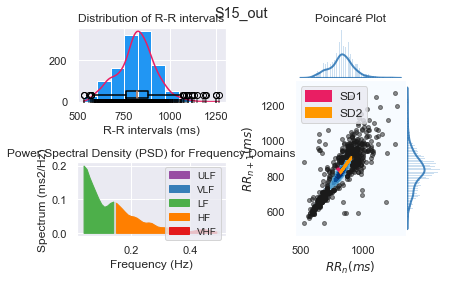

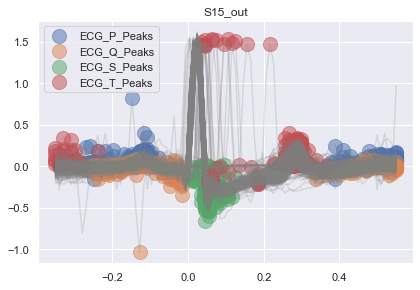

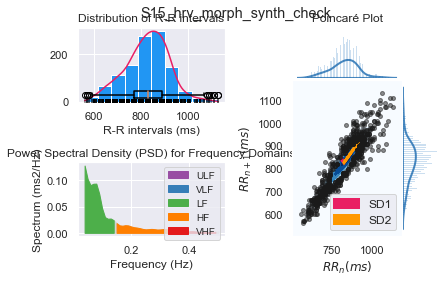

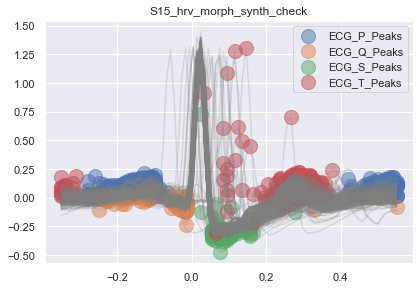

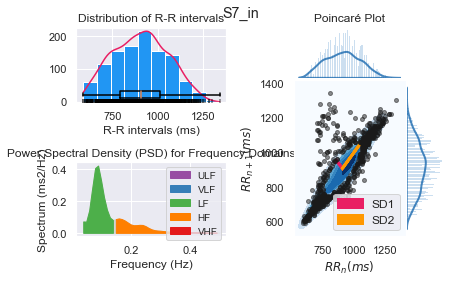

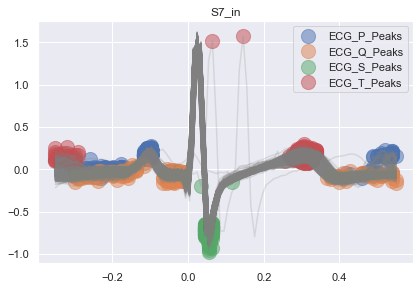

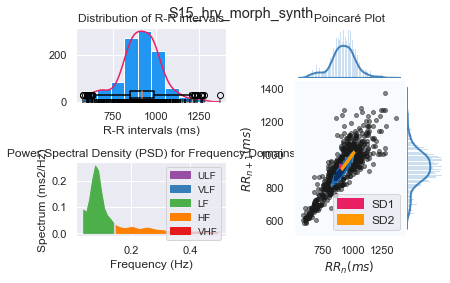

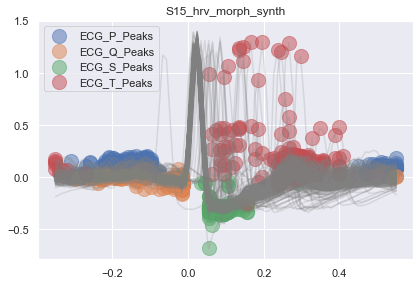

In [12]:
from CardioGen.modulators import ECG_HRV_Morph_Modulator, ECG_Morph_Modulator, ECG_HRV_Modulator
#ckpt_path='data/post-training/'
ckpt_path='./cardio_gen_model/data/post-training/'
Fs_in=100
Fs_out=100 #Synthetic signal sampling freq

# ECG HRV+Morph modulation
hrv_morph_mod=ECG_HRV_Morph_Modulator(P_ID_out=P_ID_out,
                                path=ckpt_path,
                                Fs_out=Fs_out)
# Produce synthetic from S15 to S15 itself to check performance of models
ecg_hrv_morph_mod_check,_=hrv_morph_mod(ecg_out,Fs=Fs_in)
# Produce synthetic from S7 to S15
ecg_hrv_morph_mod,_=hrv_morph_mod(ecg_in,Fs=Fs_in)

# Analyze HRV and Morphological properties
morph_features,hrv_features= hrv_morph_mod.analyse_signal(ecg_out.flatten()
                            ,Fs=Fs_in,title_hrv=P_ID_out+'_out',
                            title_morph=P_ID_out+'_out')
morph_features,hrv_features= hrv_morph_mod.analyse_signal(ecg_hrv_morph_mod_check
                            ,Fs=Fs_out,title_hrv=P_ID_out+'_hrv_morph_synth_check',
                            title_morph=P_ID_out+'_hrv_morph_synth_check')

morph_features,hrv_features= hrv_morph_mod.analyse_signal(ecg_in.flatten()
                            ,Fs=Fs_in,title_hrv=P_ID_in+'_in',
                            title_morph=P_ID_in+'_in')
morph_features,hrv_features= hrv_morph_mod.analyse_signal(ecg_hrv_morph_mod
                            ,Fs=Fs_out,title_hrv=P_ID_out+'_hrv_morph_synth',
                            title_morph=P_ID_out+'_hrv_morph_synth')

ECG Morph model Exists. Loading ...
Restored from data/post-training/model_weights_v11/S7_ecg_stitch_model\ckpt-687
Done!


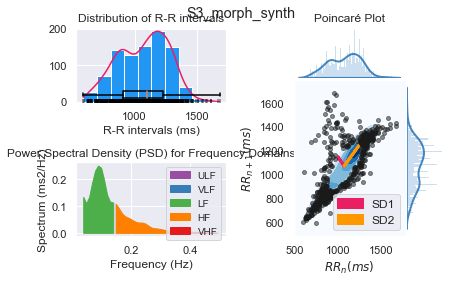

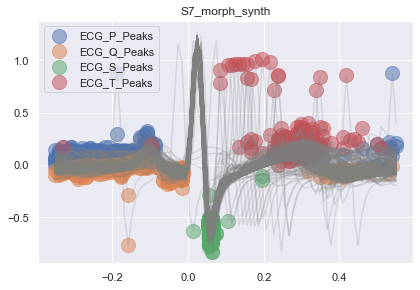

In [15]:
# ECG Morph modulation
morph_mod=ECG_Morph_Modulator(P_ID_out=P_ID_out,
                              path=ckpt_path,Fs_out=Fs_out)
ecg_morph_mod,_=morph_mod(ecg_in,Fs=Fs_in)

morph_features,hrv_features= morph_mod.analyse_signal(ecg_morph_mod
                            ,Fs=Fs_out,title_hrv=P_ID_in+'_morph_synth',
                            title_morph=P_ID_out+'_morph_synth')

HRV Gen Model Exists. Loading ...
Restored from data/post-training/model_weights_v11/W_HRV_gen_model\ckpt-2000
Done!
ECG Morph model Exists. Loading ...
Restored from data/post-training/model_weights_v11/S3_ecg_stitch_model\ckpt-687
Done!

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



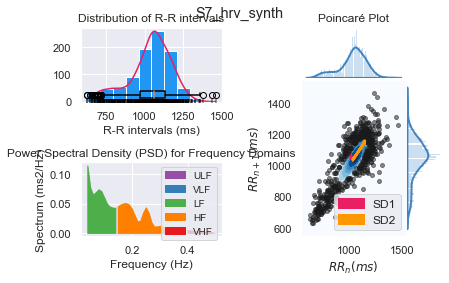

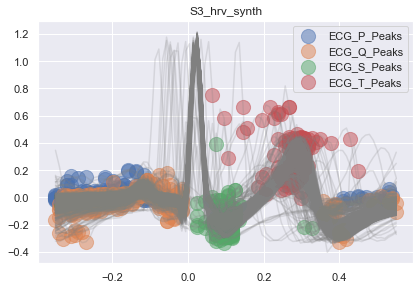

In [16]:
# ECG HRV modulation
hrv_mod=ECG_HRV_Modulator(P_ID_in=P_ID_in,P_ID_out=P_ID_out,
                              path=ckpt_path,Fs_out=Fs_out)
ecg_hrv_mod,_=hrv_mod(ecg_in,Fs=Fs_in)

morph_features,hrv_features= hrv_mod.analyse_signal(ecg_hrv_mod
                            ,Fs=Fs_out,title_hrv=P_ID_out+'_hrv_synth',
                            title_morph=P_ID_in+'_hrv_synth')